# Training Model

## Dataset 
Raw dataset can be downloaded from https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition. after the cleaning process of the dataset, the class reduced to 30 classes and change the language of the label into bahasa. Clean dataset can be accessed via https://drive.google.com/drive/folders/1Wy8-M0xPY6KlGyT_74pPvYkvY8vwlPWu?usp=sharing 

## Import library
The libraries used here are Tensorflow, Keras and several functions or pre-trained models in Keras such as Mobilenet.

In [10]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout

## Image Augmentation
To perform data augmentation, we use ImageDataGenerator to improve model performance and prevent overfitting by creating variations in the training data. Such as normalizing pixel values, rotating, reversing, and adjusting the zoom of the image.

In [11]:
# Add data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   fill_mode='nearest',
                                   horizontal_flip = True)

# validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(r"C:\ml-deploy\train",
                                                    batch_size = 32,
                                                    class_mode = 'categorical',
                                                    target_size = (224, 224))

# Flow validation images in batches of 10 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( r"C:\ml-deploy\validation",
                                                          batch_size  = 10,
                                                          class_mode  = 'categorical',
                                                          target_size = (224, 224))

train_categories = train_generator.num_classes
train_samples = train_generator.samples

print(train_samples)

Found 2580 images belonging to 30 classes.
Found 292 images belonging to 30 classes.
2580


## Load Pre-trained model
For the transfer learning model we use MobilenetV2 because this model is suitable for application on mobile devices.

In [12]:
# Load MobileNetV2 model, pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

## Model architecture
After the model has been loaded, create a model architecture to carry out transfer learning.

In [13]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(train_categories, activation='softmax')(x)

In [14]:
# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [19]:
# freeze all convolutional MobileNetV2 layers
for layer in base_model.layers:
    layer.trainable = False

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

## Compile and training model
After creating the architecture of the model, the model can then be compiled and trained.

In [16]:
# Compile the model
model.compile(
   optimizer='rmsprop',
   loss=tf.keras.losses.CategoricalCrossentropy(),
   metrics=['accuracy'])

In [17]:
history = model.fit(
   train_generator,
   epochs=20,
   validation_data=validation_generator)

Epoch 1/20


 1/81 [..............................] - ETA: 5:45 - loss: 4.2406 - accuracy: 0.0312

C:\ml-deploy\venv\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


81/81 [==============================] - 101s 1s/step - loss: 2.0237 - accuracy: 0.4310 - val_loss: 1.2893 - val_accuracy: 0.8219
Epoch 2/20
81/81 [==============================] - 93s 1s/step - loss: 1.1018 - accuracy: 0.6744 - val_loss: 0.4189 - val_accuracy: 0.8870
Epoch 3/20
81/81 [==============================] - 94s 1s/step - loss: 0.9226 - accuracy: 0.7236 - val_loss: 0.2457 - val_accuracy: 0.9315
Epoch 4/20
81/81 [==============================] - 93s 1s/step - loss: 0.7694 - accuracy: 0.7682 - val_loss: 0.2751 - val_accuracy: 0.9212
Epoch 5/20
81/81 [==============================] - 93s 1s/step - loss: 0.7014 - accuracy: 0.7829 - val_loss: 0.2954 - val_accuracy: 0.9281
Epoch 6/20
81/81 [==============================] - 94s 1s/step - loss: 0.6003 - accuracy: 0.8236 - val_loss: 0.2260 - val_accuracy: 0.9521
Epoch 7/20
81/81 [==============================] - 92s 1s/step - loss: 0.5920 - accuracy: 0.8217 - val_loss: 0.2095 - val_accuracy: 0.9623
Epoch 8/20
81/81 [============

## Model Evaluation
Evaluate the model that has been created using test data.

In [18]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        r"C:\ml-deploy\test",
        target_size=(224, 224),  # adjust this to the input size used by your model
        batch_size=10,
        class_mode='categorical')  # choose 'binary' or 'categorical' depending on your problem

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Found 299 images belonging to 30 classes.
30/30 [==============================] - 9s 312ms/step - loss: 0.2106 - accuracy: 0.9632
Test Loss: 0.21059821546077728
Test Accuracy: 0.9632107019424438


## Graphs of model accuracy and loss
Visualization can make it easier to understand the model training process, accuracy level and loss.

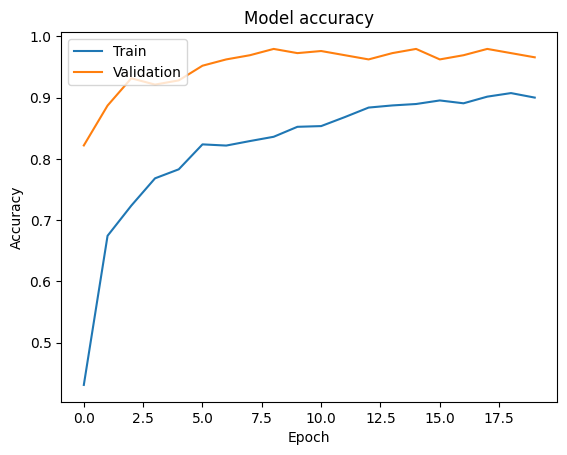

In [20]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

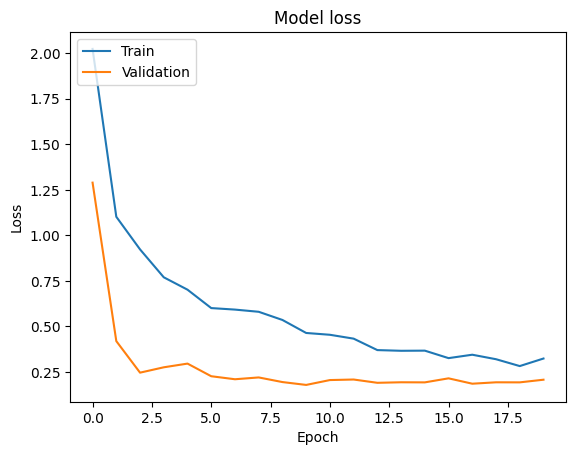

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Testing model
To find out whether the model can predict images correctly, it can be tested using new data.

In [22]:
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
import numpy as np

# Load image
img_path = r"K:\WhatsApp Image 2023-12-16 at 19.32.40_1dc5dc82.jpg"
img = load_img(img_path, target_size=(224, 224))

# Ubah gambar menjadi array dan atur nilai pixelnya
x = img_to_array(img) / 255.

x = np.expand_dims(x, axis=0)
# Buat prediksi
model = load_model('klasifikasi_gambar3.h5')
predictions = model.predict(x)

# ambil index dengan probabilitas tertinggi
top_class = np.argmax(predictions)

# Get the highest probability
top_prob = predictions[0][top_class]

# Ambil nama class sesuai dengan probabilitas tertinggi
class_names = train_generator.class_indices
class_names = dict((v,k) for k,v in class_names.items())
top_class_name = class_names[top_class]

print(f"The model predicts that the image is of class '{top_class_name}' with a probability of {top_prob*100:.2f}%.")

1/1 [==============================] - 1s 821ms/step
The model predicts that the image is of class 'cabai merah' with a probability of 99.27%.
